In [202]:
import arviz as az
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats

%matplotlib inline

#### 3.1 Sampling from a grid-approximate posterior distribution

In [2]:
# 3.1
pr_pos_test_vampire = 0.95
pr_pos_test_human = 0.01
pr_vampire = 0.001
pr_human = 1 - pr_vampire

pr_pos_test = pr_pos_test_vampire * pr_vampire + pr_pos_test_human * pr_human
pr_vampire_pos_test = (pr_pos_test_vampire * pr_vampire) / pr_pos_test
pr_vampire_pos_test

0.08683729433272395

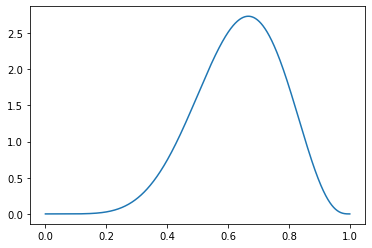

In [73]:
# 3.2 
p_grid = np.linspace(0, 1, 1000)
prob_p = np.ones((1000))
prob_data = stats.binom.pmf(k=6, n=9, p=p_grid)
posterior = prob_data * prob_p
posterior = posterior/sum(posterior)
plt.plot(p_grid, posterior*len(p_grid), '-')
pass

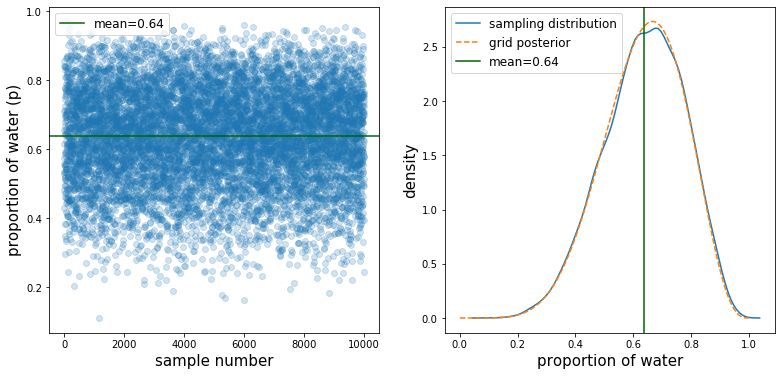

In [85]:
# 3.3, 3.4 & 3.5
np.random.seed(1063)
n_sample=int(1e4)
samples = np.random.choice(a=p_grid, size=n_sample, replace=True, p=posterior)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
ax1.plot(samples, 'o', alpha=0.2)
ax1.axhline(y=np.mean(samples), color='darkgreen',
            label='mean={}'.format(round(np.mean(samples),2)))
ax1.legend(loc=2, fontsize=12)
ax1.set_xlabel("sample number", fontsize=15)
ax1.set_ylabel("proportion of water (p)", fontsize=15)

sns.kdeplot(samples, ax=ax2, label='sampling distribution')
ax2.plot(p_grid, posterior*len(p_grid), 'C1--', label='grid posterior')
ax2.axvline(x=np.mean(samples), color='darkgreen', 
            label='mean={}'.format(round(np.mean(samples),2)))
ax2.legend(loc=2, fontsize=12)
ax2.set_xlabel("proportion of water", fontsize=15)
ax2.set_ylabel("density", fontsize=15)
pass

#### 3.2 Sampling to summarise
##### 3.2.1. Intervals of defined boundaries

In [82]:
# 3.6
# Get the posterior probability that the proportion of water is less than 0.5
sum(posterior[p_grid<0.5])

0.17187458902022879

In [95]:
# 3.7
# Same question as 3.6 but using samples instead
# sum(samples<0.5)/n_sample
np.mean(samples<0.5)

0.1749

In [96]:
# 3.8
# how much posterior probability lies between 0.5 and 0.75
np.mean((samples > 0.5) & (samples < 0.75))

0.5953

##### 3.2.2. Intervals of defined mass

In [98]:
# 3.9
# interval for the lower 80% posterior probability
np.quantile(samples, 0.8)

0.7627627627627628

In [99]:
# 3.10
# interval for the middle 80% posterior probability
np.quantile(samples, [0.1, 0.9])

array([0.44944945, 0.81481481])

In [109]:
# 3.11
# new case: 3 tossess, all water
def generate_posterior(prior, tosses, successes):
    p_grid = np.linspace(0, 1, prior.shape[0])
    likelihood= stats.binom.pmf(k=successes, n=tosses, p=p_grid)
    unstd_posterior = prior * likelihood
    std_posterior = unstd_posterior/unstd_posterior.sum()
    return p_grid, std_posterior

prior = np.ones((1000))
n, k = 3, 3
p_grid, posterior = generate_posterior(prior, n, k)
n_sample = int(1e4)
samples = np.random.choice(p_grid, size=n_sample, p=posterior)

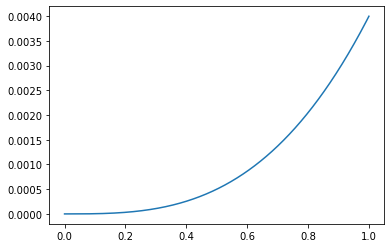

In [111]:
plt.plot(p_grid, posterior)

In [114]:
# 3.12
# middle 50% interval
# np.percentile(samples, [25,75])
np.quantile(samples, [0.25, 0.75])

array([0.71046046, 0.93293293])

In [125]:
# 3.13
# find highest posterior density interval (HPDI)
# pm.hpd(samples, 0.5)
az.hpd(samples, 0.5)

array([0.84284284, 1.        ])

##### 3.2.3. Point Estimates

In [126]:
# 3.14
# maximum a posteriori (MAP) estimate
p_grid[posterior.argmax()]

1.0

In [129]:
# 3.15
# get approximate MAP from samples
stats.mode(samples)[0]

array([0.996997])

In [130]:
# 3.16
print(np.mean(samples))
print(np.median(samples))

0.8010567567567568
0.8428428428428428


In [153]:
# 3.17
# expected loss
sum(posterior * abs(p_grid - 0.5))

0.3128751874998122

In [162]:
# 3.18
loss = np.array(list(map(lambda p: sum(posterior*abs(p_grid-p)), p_grid)))

In [163]:
# 3.19
p_grid[loss.argmin()]

0.8408408408408409

[Text(0, 0.5, 'absolute loss'), Text(0.5, 0, 'proportion of water')]

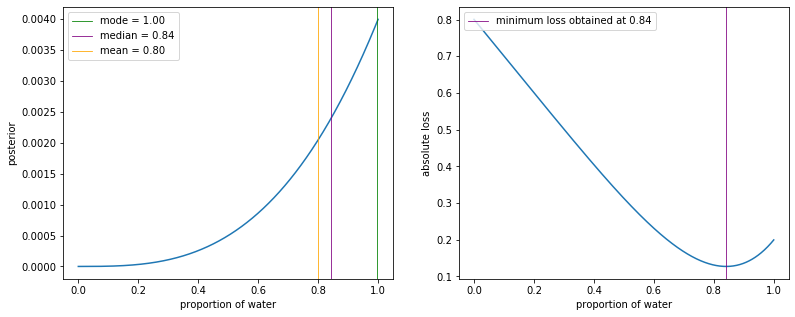

In [181]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,5))
ax1.plot(p_grid, posterior)
ax1.axvline(x=stats.mode(samples)[0], color='g', linewidth=0.8, 
            label='mode = {:.2f}'.format(stats.mode(samples)[0][0]))
ax1.axvline(x=np.median(samples), color='purple', linewidth=0.8, 
            label='median = {:.2f}'.format(np.median(samples)))
ax1.axvline(x=np.mean(samples), color='orange', linewidth=0.8, 
            label='mean = {:.2f}'.format(np.mean(samples)))
ax1.legend(loc=2)
ax1.set(xlabel="proportion of water", ylabel="posterior")

ax2.plot(p_grid, loss)
ax2.axvline(x=p_grid[loss.argmin()], color='purple', linewidth=0.8,
           label='minimum loss obtained at {:.2f}'.format(p_grid[loss.argmin()]))
ax2.legend(loc=2)
ax2.set(xlabel="proportion of water", ylabel="absolute loss")

#### 3.3 Sampling to simulate predictions

In [184]:
# 3.20
stats.binom.pmf(k=range(3), n=2, p=0.7)

array([0.09, 0.42, 0.49])

In [196]:
# 3.21
stats.binom.rvs(n=2, p=0.7, size=1)

array([1])

In [197]:
# 3.22
stats.binom.rvs(n=2, p=0.7, size=10)

array([1, 0, 1, 2, 1, 1, 2, 1, 1, 2])

In [235]:
# 3.23
dummy_w = stats.binom.rvs(n=2, p=0.7, size=int(1e5))
(pd.DataFrame(np.unique(dummy_w, return_counts=True))
 .T
 .rename(columns={0:"water", 1:"counts"})
 .assign(ratio = lambda df: df.counts / df.counts.sum())
)

,water,counts,ratio
0,0,9014,0.09014
1,1,41888,0.41888
2,2,49098,0.49098


In [279]:
# 3.24
dummy_w = stats.binom.rvs(n=9, p=0.7, size=int(1e5))

(pd.DataFrame(np.unique(dummy_w, return_counts=True))
 .T
 .rename({0:"water", 1:"counts"}, axis=1)
 .assign(ratio = lambda df: df.counts / df.counts.sum())
)

,water,counts,ratio
0,0,1,0.00001
1,1,39,0.00039
2,2,358,0.00358
3,3,2073,0.02073
4,4,7333,0.07333
5,5,17204,0.17204
6,6,26679,0.26679
7,7,26806,0.26806
8,8,15465,0.15465
9,9,4042,0.04042


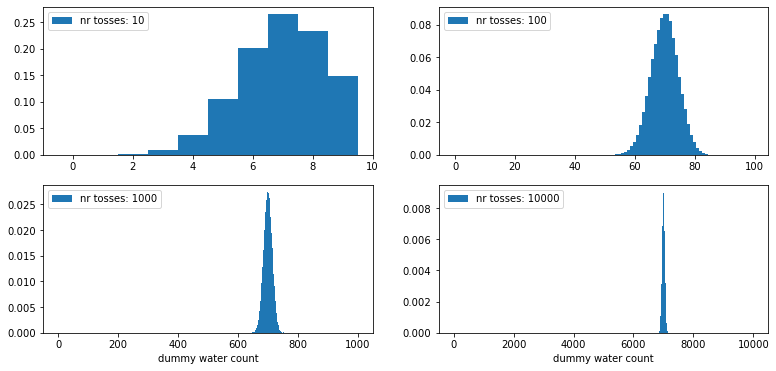

In [313]:
nr_samples = np.power(10, range(1, 5))
fig, axes = plt.subplots(2, 2, figsize=(13,6))

for idx, cax in enumerate(axes.flatten()):
    n = nr_samples[idx]
    dummy_w = stats.binom.rvs(n=n, p=0.7, size=int(1e5))
    cax.hist(dummy_w, bins=range(n+1), histtype='bar', density=True,
        align='left', label=f"nr tosses: {n}")
    cax.legend(loc=2)
    if idx >= 2:
        cax.set(xlabel="dummy water count")
pass

##### 3.3.2. Model checking

In [355]:
prior = np.ones((1000))
n, k = 9, 6
p_grid, posterior = generate_posterior(prior, n, k)
n_sample = int(1e4)
p_samples = np.random.choice(p_grid, size=n_sample, p=posterior)

In [356]:
# 3.25
obs_simulated_at_06 = stats.binom.rvs(n=9, p=0.6, size=n_sample)

In [357]:
# 3.26
obs_simulated_at_all = stats.binom.rvs(n=9, p=p_samples, size=n_sample)

In [1]:
plt.hist(obs_simulated_at_all, bins=range(11), histtype='bar', alpha=0.5, density=True,
        align='left', rwidth=0.95, 
        label='p from whole posterior')
plt.hist(obs_simulated_at_06, bins=range(11), histtype='bar', alpha=0.5, density=True,
        align='left', rwidth=0.95,
        color='orange', label='p is fixed to 0.6')
plt.xticks(range(10))
plt.xlabel("water counts")
plt.legend()
plt.title(f"Posterior Predictive Distribution: {n} tosses, {k} water")
pass

NameError: name 'plt' is not defined